In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import yfinance as yf


In [9]:

O_hat= [[ 4.02218687e-04,  5.72678475e-03],
    [ 4.02218687e-04,  5.72678475e-03],
    [ 4.02218687e-04,  5.72678475e-03]]


TypeError: list indices must be integers or slices, not tuple

In [5]:
O_plus = O_hat[:, 0]
O_minus = O_hat[:, 1]

TypeError: list indices must be integers or slices, not tuple

In [35]:
n = 5
O_hat = np.random.rand(n, 2)
type(O_hat)

numpy.ndarray

In [36]:
print(O_hat)

[[0.12315198 0.73581229]
 [0.08148393 0.53682331]
 [0.575328   0.49937642]
 [0.90934253 0.97876421]
 [0.16252951 0.33913686]]


In [37]:
print(O_hat.transpose())

[[0.12315198 0.08148393 0.575328   0.90934253 0.16252951]
 [0.73581229 0.53682331 0.49937642 0.97876421 0.33913686]]


In [38]:
O_plue = O_hat[:,0]
print(O_plue)
O_minus = O_hat[:,1]

[0.12315198 0.08148393 0.575328   0.90934253 0.16252951]


In [39]:
matrix = [O_plue, O_minus]

In [40]:
print(matrix)

[array([0.12315198, 0.08148393, 0.575328  , 0.90934253, 0.16252951]), array([0.73581229, 0.53682331, 0.49937642, 0.97876421, 0.33913686])]


In [41]:
np.array(matrix).transpose()

array([[0.12315198, 0.73581229],
       [0.08148393, 0.53682331],
       [0.575328  , 0.49937642],
       [0.90934253, 0.97876421],
       [0.16252951, 0.33913686]])

TypeError: unhashable type: 'list'

In [3]:
QQQfirms_csv_file_path = "/Users/apple/PROJECT/Code_4_10k/QQQ_constituents.csv"
firms_df = pd.read_csv(QQQfirms_csv_file_path)
firms_df = firms_df.drop(['Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'Founded'], axis=1)
firms_df['CIK'] = firms_df['CIK'].apply(lambda x: str(x).zfill(10))
firms_dict = firms_df.set_index('Symbol')['CIK'].to_dict()
firms_dict = {value: key for key, value in firms_dict.items()}


def vol_reader(comp, start_date, end_date):
    print('hi')
    stock = firms_dict[comp]
    print(stock)
    print(f'Downloading {stock} stock data')
    time_series = yf.download(stock, 
                            start = start_date,
                            end = end_date,
                            progress = False)
    def vol_proxy(ret, proxy):
        proxies = ['sqaured return', 'realized', 'daily-range', 'return']
        assert proxy in proxies, f'proxy should be in {proxies}'
        if proxy == 'realized':
            raise 'Realized volatility proxy not yet implemented'
        elif proxy == 'daily-range':
            ran = np.log(ret['High']) - np.log(ret['Low'])
            adj_factor = 4 * np.log(2)
            return np.square(ran)/adj_factor
        elif proxy == 'return':
            def ret_fun(xt_1, xt):
                return np.log(xt/xt_1)
            return ret_fun(ret['Open'], ret['Close'])
        else:
            assert proxy == 'squared return'
            raise 'Squared return proxy not yet implemented'
        
    vol_list = []
    for p in ['daily-range', 'return']:
        vol = vol_proxy(time_series, p)
        vol_list.append(vol.to_frame())
    
    df_vol = pd.concat(vol_list, axis=1)
    df_vol.columns = ['_vol', '_ret']
    df_vol = df_vol.reset_index()
    df_vol['_vol+1'] = df_vol['_vol'].shift(-1)
    df_vol['_ret+1'] = df_vol['_ret'].shift(-1)
    df_vol = df_vol.dropna()
    df_vol.set_index('Date', inplace=True)
    return df_vol

def vol_reader2(comps, start_date, end_date, window = None, extra_end = False, extra_start = False, AR = None):
    def ret_fun(xt_1, xt): # log difference
        return np.log(xt/xt_1)

    ts = []
    empty = []
    if extra_end:
        if window:
            end_date = str(dt.datetime.strptime(end_date, '%Y-%m-%d')+dt.timedelta(days=window + 3))[:10]
        else:
            end_date = str(dt.datetime.strptime(end_date, '%Y-%m-%d')+dt.timedelta(days= 1))[:10]
    if extra_start and window:
        if AR:
            start_date = str(dt.datetime.strptime(start_date, '%Y-%m-%d')-dt.timedelta(days=window*AR + 1))[:10]
        else:
            start_date = str(dt.datetime.strptime(start_date, '%Y-%m-%d')-dt.timedelta(days=window + 1))[:10]
            
    for cc in comps:
        stock = firms_dict[cc]
        print(f'Downloading {stock} stock data')
        time_series = yf.download(stock, 
                            start=start_date, 
                            end=end_date, 
                            progress=False)
        if time_series.empty:
            print(f'{stock} data is empty')
            empty.append(cc)
            continue
        ts.append(time_series)
    comps = list(set(comps) - set(empty))
        
    def vol_proxy(ret, proxy):
        proxies = ['squared return','realized','daily-range', 'return']
        assert proxy in proxies, f'proxy should be in {proxies}'
        if proxy == 'realized':
            raise 'Realized volatiliy proxy not yet implemented'
        elif proxy == 'daily-range':
            ran = np.log(ret['High']) - np.log(ret['Low'])
            adj_factor = 4*np.log(2)
            return np.square(ran)/adj_factor
        elif proxy == 'return':
            #print('Computing Open-Close log-diff returns')
            return ret_fun(ret['Open'], ret['Close'])
        else:
            assert proxy == 'squared return'
            raise 'Sqaured return proxy not yet implemented'
    
    def vol_proxy_window(ret, proxy, window):
        proxies = ['squared return', 'realized', 'daily-range', 'return']
        assert proxy in proxies, f'proxy should be in {proxies}'
        if proxy == 'return':
            t1 = ret.index + dt.timedelta(days=window-1)
            t1_adj = list(t1)
            for t in range(len(t1)):
                t_new = t1[t]
                while t_new not in ret.index:
                    t_new -= dt.timedelta(days=1)
                t1_adj[t] = t_new
            ret1 = ret.loc[t1_adj]
            ret1.index = ret.index
            remove_last = t1_adj.count(t1_adj[-1]) - 1
            if remove_last > 0:
                ret1 = ret1[:-remove_last]
                ret = ret[:-remove_last]
            return ret_fun(ret['Open'], ret1['Close'])
        elif proxy == 'realized':
            daily_ran_sq = np.square(np.log(ret['High'])-np.log(ret['Low']))/4*np.log(2)
            volvol = pd.Series(0, index=ret.index)
            for t in volvol.index:
                tt = t
                vv = 0
                N = 0
                past_date = t + dt.timedelta(days=window)
                while t < past_date:
                    if t in daily_ran_sq.index:
                        vv += daily_ran_sq.loc[t]
                        N += 1
                    t += dt.timedelta(days=1)
                volvol.loc[tt] = vv/N
            return volvol
        else:
            raise 'Proxy not introduced yet'
            
    ret_list = []
    vol_list = []
            
    if window:
        assert window > 0 and isinstance(window, int),'Incorrect window specified'
        for cc in range(len(comps)):
            ret = vol_proxy_window(ts[cc], 'return', window=window)
            ret_list.append(ret.to_frame())
            vol = vol_proxy_window(ts[cc], 'realized', window=window)
            vol_list.append(vol.to_frame())
    else:
        for cc in range(len(comps)):
            ret = vol_proxy(ts[cc], 'return')
            ret_list.append(ret.to_frame())
            vol = vol_proxy(ts[cc], 'daily-range')
            vol_list.append(vol.to_frame())
            
    df_ret = pd.concat(ret_list, axis=1)
    df_ret.columns = comps
    df_ret = df_ret.fillna(method='bfill')
    df_ret = df_ret.dropna()
    df_vol = pd.concat(vol_list, axis=1)
    df_vol.columns = comps
    df_vol = df_vol.fillna(method='bfill')
    df_vol = df_vol.dropna()
    

    return df_ret, df_vol    

In [4]:
print(firms_dict)
firms_ciks = ['0001045810']

# print(firms_dict[firms_ciks])


{'0000320193': 'AAPL', '0000796343': 'ADBE', '0000006281': 'ADI', '0000008670': 'ADP', '0000769397': 'ADSK', '0000004904': 'AEP', '0000006951': 'AMAT', '0000002488': 'AMD', '0000318154': 'AMGN', '0001018724': 'AMZN', '0001013462': 'ANSS', '0001730168': 'AVGO', '0000875045': 'BIIB', '0001075531': 'BKNG', '0001701605': 'BKR', '0000813672': 'CDNS', '0001402057': 'CDW', '0001868275': 'CEG', '0001091667': 'CHTR', '0001166691': 'CMCSA', '0000909832': 'COST', '0000900075': 'CPRT', '0000858877': 'CSCO', '0001057352': 'CSGP', '0000277948': 'CSX', '0000723254': 'CTAS', '0001058290': 'CTSH', '0000935703': 'DLTR', '0001093557': 'DXCM', '0000712515': 'EA', '0001109357': 'EXC', '0001539838': 'FANG', '0000815556': 'FAST', '0001262039': 'FTNT', '0001932393': 'GEHC', '0000882095': 'GILD', '0001652044': 'GOOGL', '0000773840': 'HON', '0000874716': 'IDXX', '0001110803': 'ILMN', '0000050863': 'INTC', '0000896878': 'INTU', '0001035267': 'ISRG', '0001418135': 'KDP', '0001637459': 'KHC', '0000319201': 'KLAC',

In [5]:

window = ['2006-01-01', '2023-12-31']
trn_window = ['2006-01-01', '2020-12-31']
vol = vol_reader('0001045810', window[0], window[1])

hi
NVDA


In [6]:
print(vol)

                _vol      _ret    _vol+1    _ret+1
Date                                              
2006-01-03  0.000875  0.038677  0.000370  0.020052
2006-01-04  0.000370  0.020052  0.000238  0.022145
2006-01-05  0.000238  0.022145  0.000848  0.004909
2006-01-06  0.000848  0.004909  0.000453  0.028021
2006-01-09  0.000453  0.028021  0.000114  0.005014
...              ...       ...       ...       ...
2023-12-21  0.000069  0.003661  0.000126 -0.007447
2023-12-22  0.000126 -0.007447  0.000061  0.006331
2023-12-26  0.000061  0.006331  0.000052 -0.001900
2023-12-27  0.000052 -0.001900  0.000033 -0.002440
2023-12-28  0.000033 -0.002440  0.000230 -0.005859

[4528 rows x 4 columns]


In [7]:
ret_trn, vol_trn = vol_reader2(firms_ciks, trn_window[0], trn_window[1], window=3, extra_end=True, extra_start=True)

In [8]:
ret_list = []
for ret in ret_trn.values.tolist():
    ret_list.append(ret[0])

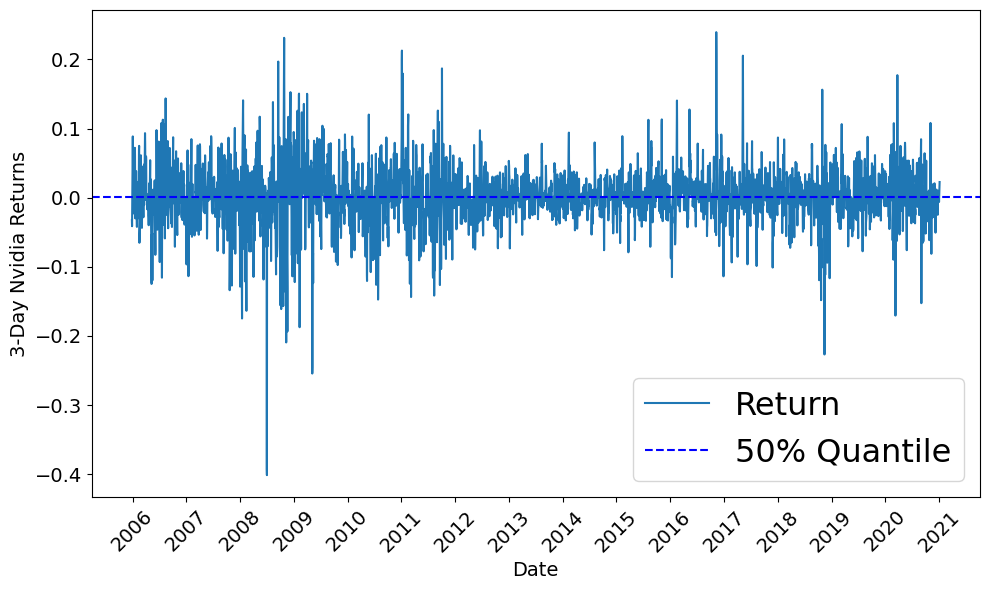

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter
# Let's assume you have a DataFrame 'df' with a Date column for the X-axis and a Volatility column for the Y-axis.

# Sample data generation (replace this with your actual data)

df = pd.DataFrame({'Date': ret_trn.index, 'Return': ret_list})

# Calculate quantiles
q50 = df['Return'].quantile(0.50)
q65 = df['Return'].quantile(0.65)
q80 = df['Return'].quantile(0.80)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Return'], label='Return')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


# Add horizontal lines for the 50% and 80% quantiles
plt.axhline(y=q50, color='b', linestyle='--', label='50% Quantile')
# plt.axhline(y=q65, color='r', linestyle='--', label='65% Quantile')
# plt.axhline(y=q80, color='g', linestyle='--', label='80% Quantile')


# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('3-Day Nvidia Returns', fontsize=14)


# Show the legend
plt.legend(fontsize=23)

# Rotate date labels
plt.xticks(rotation=45,)

# Increase tick labels font size
plt.tick_params(axis='both', which='major', labelsize=14)
# Show the plot
plt.tight_layout()
plt.show()


In [10]:
print(vol_trn)
print(vol_trn.index.tolist())
datetime_index_list = vol_trn.index.tolist()
datetime_list = [timestamp.strftime('%Y-%m-%d') for timestamp in datetime_index_list]
print(datetime_list)
print(vol_trn.values.tolist())
vol_list = []
for e in vol_trn.values.tolist():
    vol_list.append(e[0])
    

            0001045810
Date                  
2005-12-28    0.000089
2005-12-29    0.000103
2005-12-30    0.000056
2006-01-03    0.000237
2006-01-04    0.000233
...                ...
2020-12-29    0.000071
2020-12-30    0.000080
2020-12-31    0.000057
2021-01-04    0.000296
2021-01-05    0.000125

[3781 rows x 1 columns]
[Timestamp('2005-12-28 00:00:00'), Timestamp('2005-12-29 00:00:00'), Timestamp('2005-12-30 00:00:00'), Timestamp('2006-01-03 00:00:00'), Timestamp('2006-01-04 00:00:00'), Timestamp('2006-01-05 00:00:00'), Timestamp('2006-01-06 00:00:00'), Timestamp('2006-01-09 00:00:00'), Timestamp('2006-01-10 00:00:00'), Timestamp('2006-01-11 00:00:00'), Timestamp('2006-01-12 00:00:00'), Timestamp('2006-01-13 00:00:00'), Timestamp('2006-01-17 00:00:00'), Timestamp('2006-01-18 00:00:00'), Timestamp('2006-01-19 00:00:00'), Timestamp('2006-01-20 00:00:00'), Timestamp('2006-01-23 00:00:00'), Timestamp('2006-01-24 00:00:00'), Timestamp('2006-01-25 00:00:00'), Timestamp('2006-01-26 00:00:0

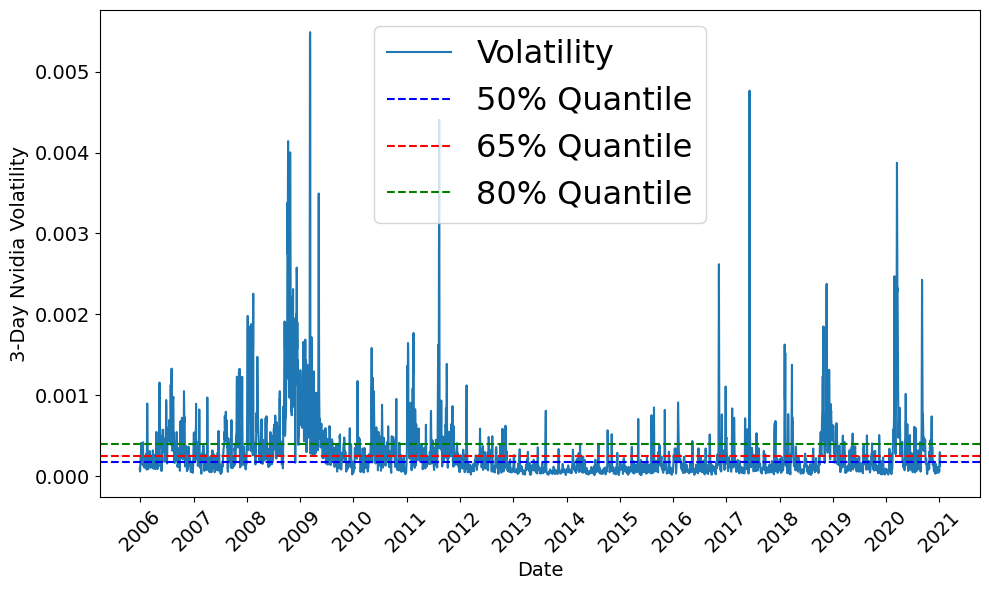

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter
# Let's assume you have a DataFrame 'df' with a Date column for the X-axis and a Volatility column for the Y-axis.

# Sample data generation (replace this with your actual data)

df = pd.DataFrame({'Date': vol_trn.index, 'Volatility': vol_list})

# Calculate quantiles
q50 = df['Volatility'].quantile(0.50)
q65 = df['Volatility'].quantile(0.65)
q80 = df['Volatility'].quantile(0.80)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Volatility'], label='Volatility')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


# Add horizontal lines for the 50% and 80% quantiles
plt.axhline(y=q50, color='b', linestyle='--', label='50% Quantile')
plt.axhline(y=q65, color='r', linestyle='--', label='65% Quantile')
plt.axhline(y=q80, color='g', linestyle='--', label='80% Quantile')


# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('3-Day Nvidia Volatility', fontsize=14)


# Show the legend
plt.legend(fontsize=23)

# Rotate date labels
plt.xticks(rotation=45,)

# Increase tick labels font size
plt.tick_params(axis='both', which='major', labelsize=14)
# Show the plot
plt.tight_layout()
plt.show()


In [12]:
QQQfirms_csv_file_path =  "/Users/apple/PROJECT/Code_4_10k/top10_QQQ_constituents.csv"
firms_df = pd.read_csv(QQQfirms_csv_file_path)
firms_df = firms_df.drop(['Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'Founded'], axis=1)
firms_df['CIK'] = firms_df['CIK'].apply(lambda x: str(x).zfill(10))
seen = set()
firms_ciks = [cik for cik in firms_df['CIK'].tolist() if not (cik in seen or seen.add(cik))] 
top10_ret_trn, top10_vol_trn = vol_reader2(firms_ciks, trn_window[0], trn_window[1], window=3, extra_end=True, extra_start=True)



In [21]:

datetime_index_list = top10_vol_trn.index.tolist()
datetime_list = [timestamp.strftime('%Y-%m-%d') for timestamp in datetime_index_list]
vol_list = []
for e in top10_vol_trn.values.tolist():
    vol_list.append(e)

In [22]:
# Weights
comp_to_weight_value = {
    '0000320193': 7.44,  # Apple
    '0000789019': 8.60,  # Microsoft
    '0001018724': 5.17,  # Amazon
    '0001730168': 4.80,   # Broadcom
    '0001326801': 5.12,   # Meta (formerly Facebook)
    '0001045810': 6.48,   # NVIDIA
    '0001318605': 2.43,   # Tesla - 2019-12-31: 75.71 B, 2020-12-31: 668.09 B
    '0001652044': 4.43, # Alphabet (Google)
    '0000909832': 2.54    # Costco
}


In [23]:
port_weights = np.array([comp_to_weight_value[c] for c in firms_ciks])
port_weights = port_weights/sum(port_weights)
weight = pd.DataFrame(pd.Series(port_weights, index=top10_vol_trn.columns, name=0))

port_val_vol = top10_vol_trn.dot(weight[0])
print("Hi you are using value portfolio")
print(port_val_vol)

Hi you are using value portfolio
Date
2005-12-28    0.001434
2005-12-29    0.001442
2005-12-30    0.001435
2006-01-03    0.001481
2006-01-04    0.001463
                ...   
2020-12-29    0.000075
2020-12-30    0.000074
2020-12-31    0.000066
2021-01-04    0.000192
2021-01-05    0.000070
Length: 3781, dtype: float64


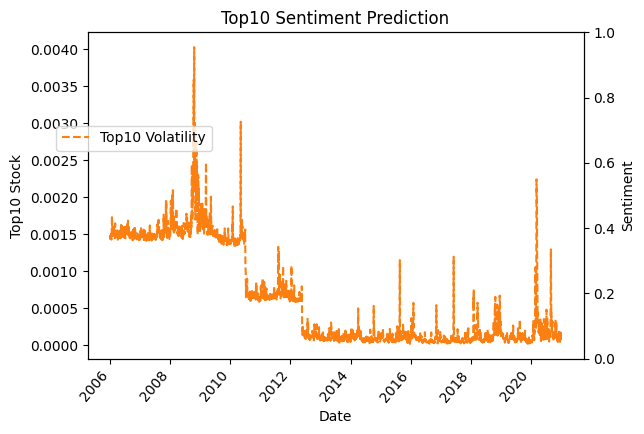

In [24]:
TEMP ='Top10'
NAME = 'Top10'
fig, ax = plt.subplots()

ax.plot(port_val_vol, color = '#FB7F11', linestyle = 'dashed', label = f'{TEMP} Volatility')

ax.set_xlabel("Date")
ax.set_ylabel(f'{TEMP} Stock')
ax2 = ax.twinx()


ax2.set_ylabel('Sentiment')
fig.legend(bbox_to_anchor = (0.33, 0.7))
fig.autofmt_xdate(rotation=50)
plt.title(f'{NAME} Sentiment Prediction')

plt.show()

In [18]:
print(top10_vol_trn.values.tolist())

[[0.00013447356118999893, 4.5022807795421046e-05, 0.0007716204983267228, 3.7174463111109086e-05, 4.9670071903776746e-05, 1.6392235848496554e-05, 8.910391130774414e-05, 0.014853465433477717, 0.0049537158877857165], [0.0001689338195846126, 5.1793236625909815e-05, 0.0007716204983267228, 4.023779820246441e-05, 5.406648799593473e-05, 1.273580786615915e-05, 0.00010322274478169839, 0.014853465433477717, 0.0049537158877857165], [0.00014856254802822518, 8.568843557134711e-05, 0.0007716204983267228, 7.101100404764277e-05, 2.00104503832097e-05, 1.1128499106592692e-05, 5.592414225651451e-05, 0.014853465433477717, 0.0049537158877857165], [0.00010301935999123644, 0.0001250660760738809, 0.0007716204983267228, 7.725045797039974e-05, 0.00015059794142111533, 7.787340556997516e-05, 0.00023735291804618904, 0.014853465433477717, 0.0049537158877857165], [8.287272100719485e-05, 9.814450694441331e-05, 0.0007716204983267228, 4.243875359744829e-05, 0.00013476300068450135, 3.249157729704061e-05, 0.00023306512859

In [107]:
print(top10_vol_trn)

            0001730168  0000789019  0000320193  0001652044  0001018724  \
Date                                                                     
2005-12-28    0.000134    0.000045    0.000772    0.000037    0.000050   
2005-12-29    0.000169    0.000052    0.000772    0.000040    0.000054   
2005-12-30    0.000149    0.000086    0.000772    0.000071    0.000020   
2006-01-03    0.000103    0.000125    0.000772    0.000077    0.000151   
2006-01-04    0.000083    0.000098    0.000772    0.000042    0.000135   
...                ...         ...         ...         ...         ...   
2020-12-29    0.000112    0.000053    0.000054    0.000015    0.000059   
2020-12-30    0.000077    0.000042    0.000042    0.000017    0.000058   
2020-12-31    0.000089    0.000028    0.000027    0.000026    0.000026   
2021-01-04    0.000296    0.000167    0.000228    0.000042    0.000114   
2021-01-05    0.000112    0.000058    0.000047    0.000030    0.000052   

            0001326801  0001045810  0

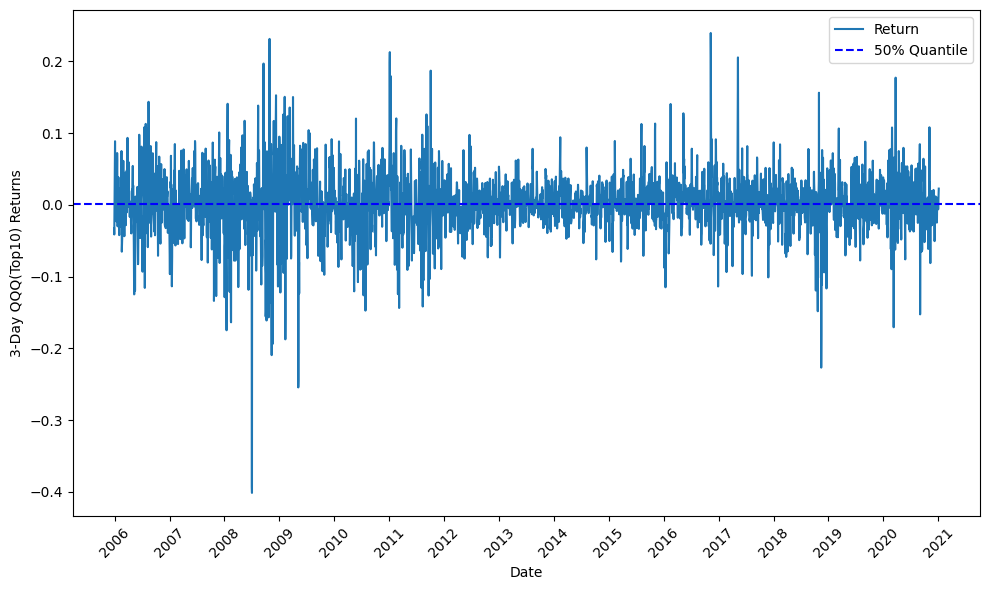

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter
# Let's assume you have a DataFrame 'df' with a Date column for the X-axis and a Volatility column for the Y-axis.

# Sample data generation (replace this with your actual data)

df = pd.DataFrame({'Date': ret_trn.index, 'Return': ret_list})

# Calculate quantiles
q50 = df['Return'].quantile(0.50)
q65 = df['Return'].quantile(0.65)
q80 = df['Return'].quantile(0.80)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Return'], label='Return')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


# Add horizontal lines for the 50% and 80% quantiles
plt.axhline(y=q50, color='b', linestyle='--', label='50% Quantile')
# plt.axhline(y=q65, color='r', linestyle='--', label='65% Quantile')
# plt.axhline(y=q80, color='g', linestyle='--', label='80% Quantile')


# Add labels and title
plt.xlabel('Date')
plt.ylabel('3-Day QQQ(Top10) Returns')


# Show the legend
plt.legend()

# Rotate date labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


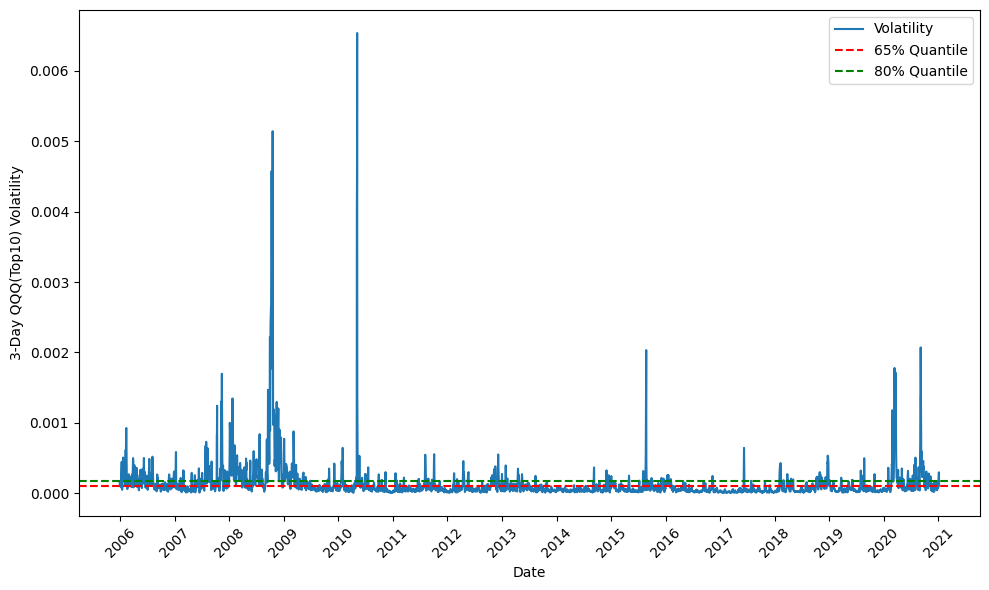

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter
# Let's assume you have a DataFrame 'df' with a Date column for the X-axis and a Volatility column for the Y-axis.

# Sample data generation (replace this with your actual data)

df = pd.DataFrame({'Date': top10_vol_trn.index, 'Volatility': vol_list})

# Calculate quantiles

q65 = df['Volatility'].quantile(0.65)
q80 = df['Volatility'].quantile(0.80)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Volatility'], label='Volatility')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


# Add horizontal lines for the 50% and 80% quantiles

plt.axhline(y=q65, color='r', linestyle='--', label='65% Quantile')
plt.axhline(y=q80, color='g', linestyle='--', label='80% Quantile')


# Add labels and title
plt.xlabel('Date')
plt.ylabel('3-Day QQQ(Top10) Volatility')


# Show the legend
plt.legend()

# Rotate date labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [168]:
QQQfirms_csv_file_path =  "/Users/apple/PROJECT/Code_4_10k/QQQ_constituents.csv"
firms_df = pd.read_csv(QQQfirms_csv_file_path)
firms_df = firms_df.drop(['Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'Founded'], axis=1)
firms_df['CIK'] = firms_df['CIK'].apply(lambda x: str(x).zfill(10))
seen = set()
firms_ciks = [cik for cik in firms_df['CIK'].tolist() if not (cik in seen or seen.add(cik))] 
ret_trn, vol_trn = vol_reader2(firms_ciks, trn_window[0], trn_window[1], window=3, extra_end=True, extra_start=True)
datetime_index_list = vol_trn.index.tolist()
datetime_list = [timestamp.strftime('%Y-%m-%d') for timestamp in datetime_index_list]
vol_list = []
for e in vol_trn.values.tolist():
    vol_list.append(e[0])



1 Failed download:
['CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1135746000, endDate = 1609909200")


CEG data is empty



1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1135746000, endDate = 1609909200")


GEHC data is empty



1 Failed download:
['GFS']: Exception("%ticker%: Data doesn't exist for startDate = 1135746000, endDate = 1609909200")


GFS data is empty


In [165]:
print(vol_list)

[0.00013447356118999893, 0.0001689338195846126, 0.00014856254802822518, 0.00010301935999123644, 8.287272100719485e-05, 9.078246336223012e-05, 0.00014007924739975556, 0.00040276851005390625, 0.00044349400734662375, 0.00011784263679990416, 0.00011634611712806999, 4.734450736688312e-05, 0.00016745155093940826, 0.0002858614409966248, 0.00036783767405122335, 0.000505912236847973, 0.00043264565862246137, 0.0004419869440488765, 0.000383109139384761, 0.00029905615827802823, 0.00020694229123962863, 0.00045151576798216337, 0.00021887486363600657, 0.00018426712278459226, 0.0002261140972316512, 0.00010262316779424483, 0.000615058233754183, 0.0005033973703481788, 0.0007142948225004124, 0.0008911959328357973, 0.0009258937137972066, 0.00028734337870646985, 0.0002551500289197039, 0.00014894884353973102, 6.987342586949584e-05, 5.753440362331899e-05, 0.00024028920878026063, 0.0002186917844056791, 8.863697441156327e-05, 9.536091127564023e-05, 0.00026745203971693634, 0.00026389607219940976, 0.000116643837

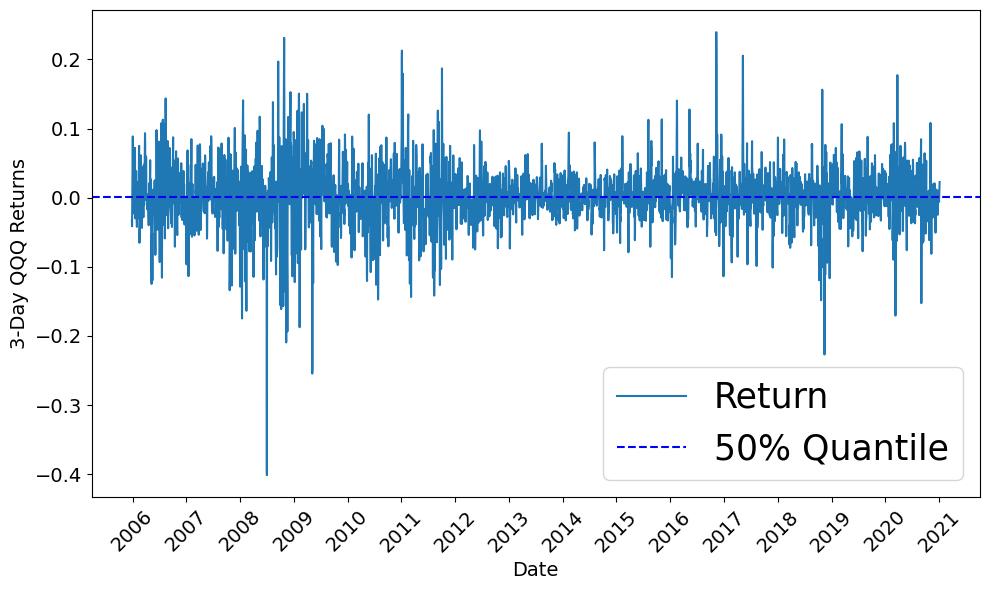

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter
# Let's assume you have a DataFrame 'df' with a Date column for the X-axis and a Volatility column for the Y-axis.

# Sample data generation (replace this with your actual data)

df = pd.DataFrame({'Date': ret_trn.index, 'Return': ret_list})

# Calculate quantiles
q50 = df['Return'].quantile(0.50)
q65 = df['Return'].quantile(0.65)
q80 = df['Return'].quantile(0.80)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Return'], label='Return')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


# Add horizontal lines for the 50% and 80% quantiles
plt.axhline(y=q50, color='b', linestyle='--', label='50% Quantile')
# plt.axhline(y=q65, color='r', linestyle='--', label='65% Quantile')
# plt.axhline(y=q80, color='g', linestyle='--', label='80% Quantile')


# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('3-Day QQQ Returns', fontsize=14)


# Show the legend
plt.legend(fontsize=25)

# Rotate date labels
plt.xticks(rotation=45,)

# Increase tick labels font size
plt.tick_params(axis='both', which='major', labelsize=14)
# Show the plot
plt.tight_layout()
plt.show()


In [169]:
print(vol_trn)
print('vol_list', vol_list)

            0001637459  0000796343  0000882835  0000072903  0000745732  \
Date                                                                     
2005-12-28    0.000134    0.000041    0.000030    0.000015    0.000079   
2005-12-29    0.000169    0.000034    0.000031    0.000019    0.000098   
2005-12-30    0.000149    0.000033    0.000027    0.000011    0.000176   
2006-01-03    0.000103    0.000369    0.000174    0.000029    0.000121   
2006-01-04    0.000083    0.000088    0.000124    0.000018    0.000283   
...                ...         ...         ...         ...         ...   
2020-12-29    0.000112    0.000030    0.000042    0.000054    0.000059   
2020-12-30    0.000077    0.000034    0.000036    0.000052    0.000057   
2020-12-31    0.000089    0.000023    0.000037    0.000055    0.000089   
2021-01-04    0.000296    0.000236    0.000189    0.000253    0.000244   
2021-01-05    0.000112    0.000035    0.000100    0.000048    0.000069   

            0001048286  0001774585  0

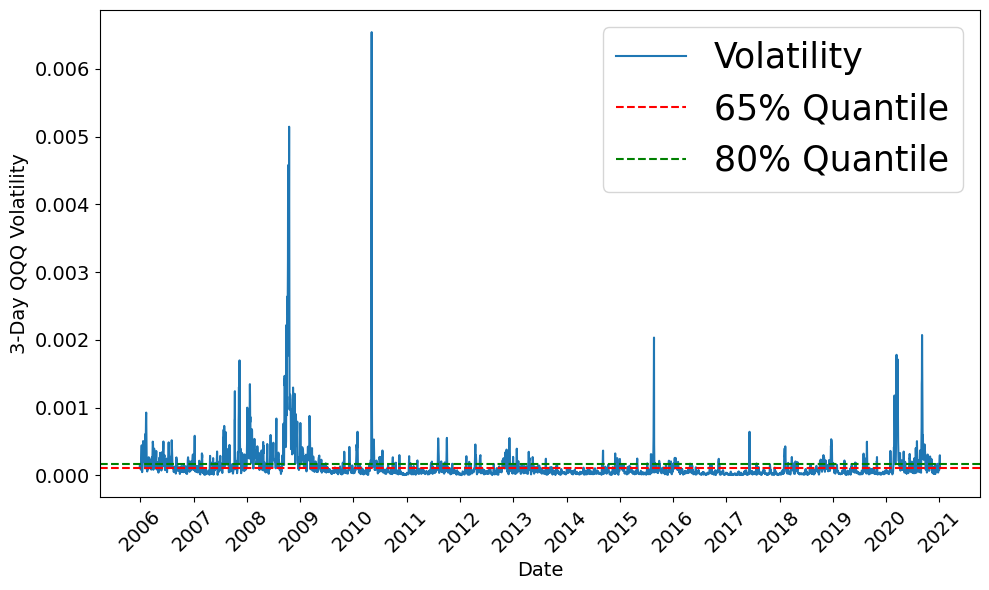

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter
# Let's assume you have a DataFrame 'df' with a Date column for the X-axis and a Volatility column for the Y-axis.

# Sample data generation (replace this with your actual data)

df = pd.DataFrame({'Date': vol_trn.index, 'Volatility': vol_list})

# Calculate quantiles

q65 = df['Volatility'].quantile(0.65)
q80 = df['Volatility'].quantile(0.80)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Volatility'], label='Volatility')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())


# Add horizontal lines for the 50% and 80% quantiles

plt.axhline(y=q65, color='r', linestyle='--', label='65% Quantile')
plt.axhline(y=q80, color='g', linestyle='--', label='80% Quantile')


# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('3-Day QQQ Volatility', fontsize=14)


# Show the legend
plt.legend(fontsize=25)

# Rotate date labels
plt.xticks(rotation=45,)

# Increase tick labels font size
plt.tick_params(axis='both', which='major', labelsize=14)
# Show the plot
plt.tight_layout()
plt.show()


In [61]:
scores = [5,6,2,1,3,45,34]
# scores = [5,6,1]

sorted_list = []
def sort_recurr(scores):

    value = max(scores)
    sorted_list.append(value)
    # print(sorted_list)
    # print(scores)
    scores.remove(value)
    # print(scores)
    if not scores:
        # print(sorted_list)
        return sorted_list
    return sort_recurr(scores)

result = sort_recurr(scores)
print(result)

[45, 34, 6, 5, 3, 2, 1]


In [50]:
value = []
scores = []
print(scores.remove(value))
# if not value:
#     print('hi')

ValueError: list.remove(x): x not in list

In [17]:
list = [1,5,2,1,4,6,2]
max(list)

6